In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Dataset Definition
class GaussianBumpDataset(Dataset):
    def __init__(self, num_samples=1000, grid_size=28, sigma=1.0):
        self.num_samples = num_samples
        self.grid_size = grid_size
        self.sigma = sigma
        self.data = []
        self.targets = []

        for _ in range(num_samples):
            x, y = np.random.uniform(0, grid_size, size=2)  # Use continuous values for x and y
            gaussian_x = np.exp(-((np.arange(grid_size) - x) ** 2) / (2 * sigma ** 2))
            gaussian_y = np.exp(-((np.arange(grid_size) - y) ** 2) / (2 * sigma ** 2))

            xv, yv = np.meshgrid(np.arange(grid_size), np.arange(grid_size))
            gaussian_image = 1.0 - np.exp(-((xv - x) ** 2 + (yv - y) ** 2) / (2 * sigma ** 2))

            self.data.append(np.array([x, y]))  # Store x and y as a 2D vector
            self.targets.append(gaussian_image)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32).unsqueeze(0)

# Model Definition with Variable Depth
class MLPDecoder(nn.Module):
    def __init__(self, input_size=2, hidden_sizes=[128, 128], output_size=28*28):
        super(MLPDecoder, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layer = nn.Linear(prev_size, hidden_size)
            nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
            self.hidden_layers.append(layer)
            self.bn_layers.append(nn.BatchNorm1d(hidden_size))
            prev_size = hidden_size
        self.output_layer = nn.Linear(prev_size, output_size)

    def forward(self, x):
        for layer, bn in zip(self.hidden_layers, self.bn_layers):
            x = bn(layer(x))
            x = F.relu(x)
        x = self.output_layer(x)
        x = x.view(-1, 1, 28, 28)
        return x

    def forward_with_activations(self, x):
        activations = []
        for layer in self.hidden_layers:
            x = layer(x)
            x = F.leaky_relu(x)
            activations.append(x.clone())
        x = self.output_layer(x)
        activations.append(x.clone())
        x = x.view(-1, 1, 28, 28)
        return x, activations

# Training Setup
def train_model(model, dataloader, num_epochs=20, learning_rate=1e-3, print_gradients=False, grad_print_interval=1, device="cuda"):
    # Move model to device
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    avg_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            # Move inputs and targets to device
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Optional: Print gradients per layer
            if print_gradients and (epoch % grad_print_interval == 0) and (batch_idx == 0):
                print(f"Epoch {epoch+1}, Batch {batch_idx+1}:")
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        grad_norm = param.grad.data.norm(2).item()
                        print(f"  Layer {name}: Gradient Norm = {grad_norm:.6f}")
                    else:
                        print(f"  Layer {name}: No gradient")
            
            optimizer.step()
            running_loss += loss.item()
    
        avg_loss = running_loss / len(dataloader)
        avg_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
        scheduler.step(avg_loss)
    return avg_losses

# Visualization and Evaluation
def evaluate_model(model, dataloader, device="cuda"):
    model = model.to(device)
    model.eval()
    mse_loss = 0.0
    criterion = nn.MSELoss()
    num_samples = 4
    sampled_inputs, sampled_targets, sampled_outputs = [], [], []

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            # Move inputs and targets to device
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            mse_loss += criterion(outputs, targets).item() * inputs.size(0)

            if batch_idx < num_samples:
                sampled_inputs.append(inputs.cpu())
                sampled_targets.append(targets.cpu())
                sampled_outputs.append(outputs.cpu())

    mse_loss /= len(dataloader.dataset)
    print(f"Mean Squared Error on Evaluation: {mse_loss:.4f}")

    # Plot sampled images
    for i in range(num_samples):
        input_coords = sampled_inputs[i][0].numpy()
        target_image = sampled_targets[i][0].squeeze().numpy()
        output_image = sampled_outputs[i][0].squeeze().numpy()

        x, y = input_coords[0], input_coords[1]

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.title("Target Image")
        plt.imshow(target_image, cmap='gray')
        plt.scatter([x], [y], color='red', marker='x')
        plt.subplot(1, 2, 2)
        plt.title("Reconstructed Image")
        plt.imshow(output_image, cmap='gray')
        plt.scatter([x], [y], color='red', marker='x')
        plt.show()

Epoch [1/100], Loss: 0.1238
Epoch [2/100], Loss: 0.0138
Epoch [3/100], Loss: 0.0098
Epoch [4/100], Loss: 0.0099
Epoch [5/100], Loss: 0.0086
Epoch [6/100], Loss: 0.0072
Epoch [7/100], Loss: 0.0080
Epoch [8/100], Loss: 0.0069
Epoch [9/100], Loss: 0.0061
Epoch [10/100], Loss: 0.0069
Epoch [11/100], Loss: 0.0067
Epoch [12/100], Loss: 0.0058
Epoch [13/100], Loss: 0.0060
Epoch [14/100], Loss: 0.0061
Epoch [15/100], Loss: 0.0074
Epoch [16/100], Loss: 0.0055
Epoch [17/100], Loss: 0.0056
Epoch [18/100], Loss: 0.0054
Epoch [19/100], Loss: 0.0048
Epoch [20/100], Loss: 0.0047
Epoch [21/100], Loss: 0.0055
Epoch [22/100], Loss: 0.0049
Epoch [23/100], Loss: 0.0050
Epoch [24/100], Loss: 0.0052
Epoch [25/100], Loss: 0.0061
Epoch [26/100], Loss: 0.0078
Epoch [27/100], Loss: 0.0052
Epoch [28/100], Loss: 0.0043
Epoch [29/100], Loss: 0.0045
Epoch [30/100], Loss: 0.0042
Epoch [31/100], Loss: 0.0042
Epoch [32/100], Loss: 0.0044
Epoch [33/100], Loss: 0.0042
Epoch [34/100], Loss: 0.0041
Epoch [35/100], Loss: 0

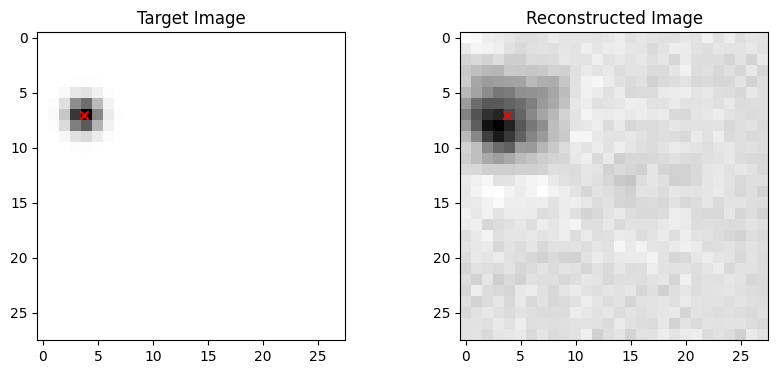

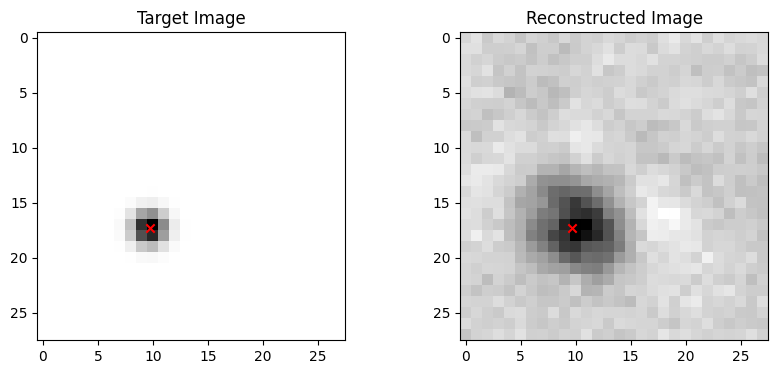

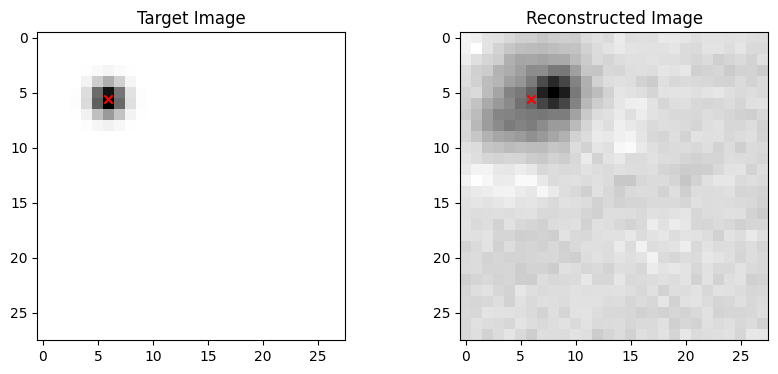

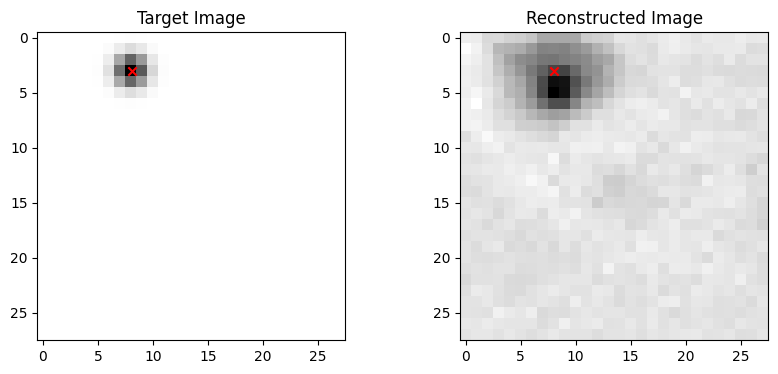

In [2]:
# Hyperparameters
input_size = 2
hidden_sizes = [1024] * 10
output_size = 28 * 28
batch_size = 32
num_epochs = 100
learning_rate = 1e-3

# Dataset and DataLoader
dataset = GaussianBumpDataset(num_samples=1000, grid_size=28)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model Initialization
model = MLPDecoder(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size)

# Train the model
avg_loss_list2 = train_model(model, dataloader, num_epochs=num_epochs, learning_rate=learning_rate, print_gradients=False)

# Evaluate the model and visualize some samples
evaluate_model(model, dataloader)

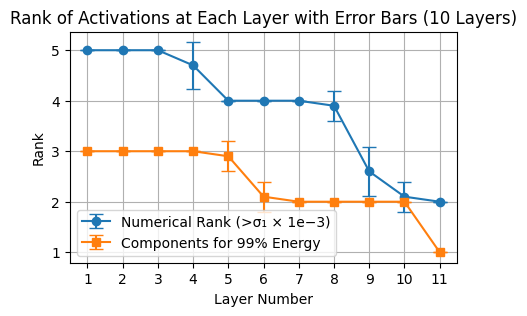

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Assuming GaussianBumpDataset and model are defined elsewhere

# Create the test dataset and DataLoader
test_dataset = GaussianBumpDataset(num_samples=1000)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

# Initialize lists to store activations per layer
num_layers = len(hidden_sizes) + 1  # Number of hidden layers plus the output layer
layer_numbers = list(range(1, num_layers + 1))  # [1, 2, ..., num_layers]

# Initialize lists to store ranks for each batch
effective_ranks_per_layer = []
ranks_99_per_layer = []

# Ensure the model is in evaluation mode
model.eval()

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for inputs, _ in test_loader:
    # Move inputs to GPU if available
    inputs = inputs.to(device)
    
    # Perform forward pass with activations
    with torch.no_grad():
        outputs, activations = model.forward_with_activations(inputs)
    
    batch_effective_ranks = []
    batch_ranks_99 = []
    
    for activation in activations:
        # Move activations to CPU and convert to NumPy array
        activation = activation.detach().to(device).cpu().numpy()
        # Center the activations by subtracting the mean
        activation_centered = activation - np.mean(activation, axis=0)
        n_samples = activation_centered.shape[0]
        
        # Compute the sample covariance matrix: C = (1/n) * X_centered^T X_centered
        covariance_matrix = (1.0 / n_samples) * np.dot(activation_centered.T, activation_centered)
        
        # Compute eigenvalues of the covariance matrix
        eigenvalues = np.linalg.eigvalsh(covariance_matrix)
        eigenvalues = eigenvalues[::-1]  # Sort in descending order
        
        # Threshold σ = σ₁ × 1e−3
        sigma = eigenvalues[0] * 1e-3
        
        # Compute numerical rank
        effective_rank = np.sum(eigenvalues > sigma)
        batch_effective_ranks.append(effective_rank)
        
        # Compute components for 99% energy
        total_energy = np.sum(eigenvalues)
        cumulative_energy = np.cumsum(eigenvalues)
        num_components_99 = np.searchsorted(cumulative_energy, 0.99 * total_energy) + 1
        batch_ranks_99.append(num_components_99)
    
    effective_ranks_per_layer.append(batch_effective_ranks)
    ranks_99_per_layer.append(batch_ranks_99)

# Convert lists to NumPy arrays
effective_ranks_per_layer = np.array(effective_ranks_per_layer)
ranks_99_per_layer = np.array(ranks_99_per_layer)

# Calculate mean and standard deviation
mean_effective_ranks = np.mean(effective_ranks_per_layer, axis=0)
std_effective_ranks = np.std(effective_ranks_per_layer, axis=0)
mean_ranks_99 = np.mean(ranks_99_per_layer, axis=0)
std_ranks_99 = np.std(ranks_99_per_layer, axis=0)

# Plotting the ranks with error bars
plt.figure(figsize=(5, 3))
plt.errorbar(layer_numbers, mean_effective_ranks, yerr=std_effective_ranks, fmt='-o', capsize=5, label='Numerical Rank (>σ₁ × 1e−3)')
plt.errorbar(layer_numbers, mean_ranks_99, yerr=std_ranks_99, fmt='-s', capsize=5, label='Components for 99% Energy')
plt.title('Rank of Activations at Each Layer with Error Bars (10 Layers)')
plt.xlabel('Layer Number')
plt.ylabel('Rank')
plt.xticks(layer_numbers)
plt.legend()
plt.grid(True)
plt.show()

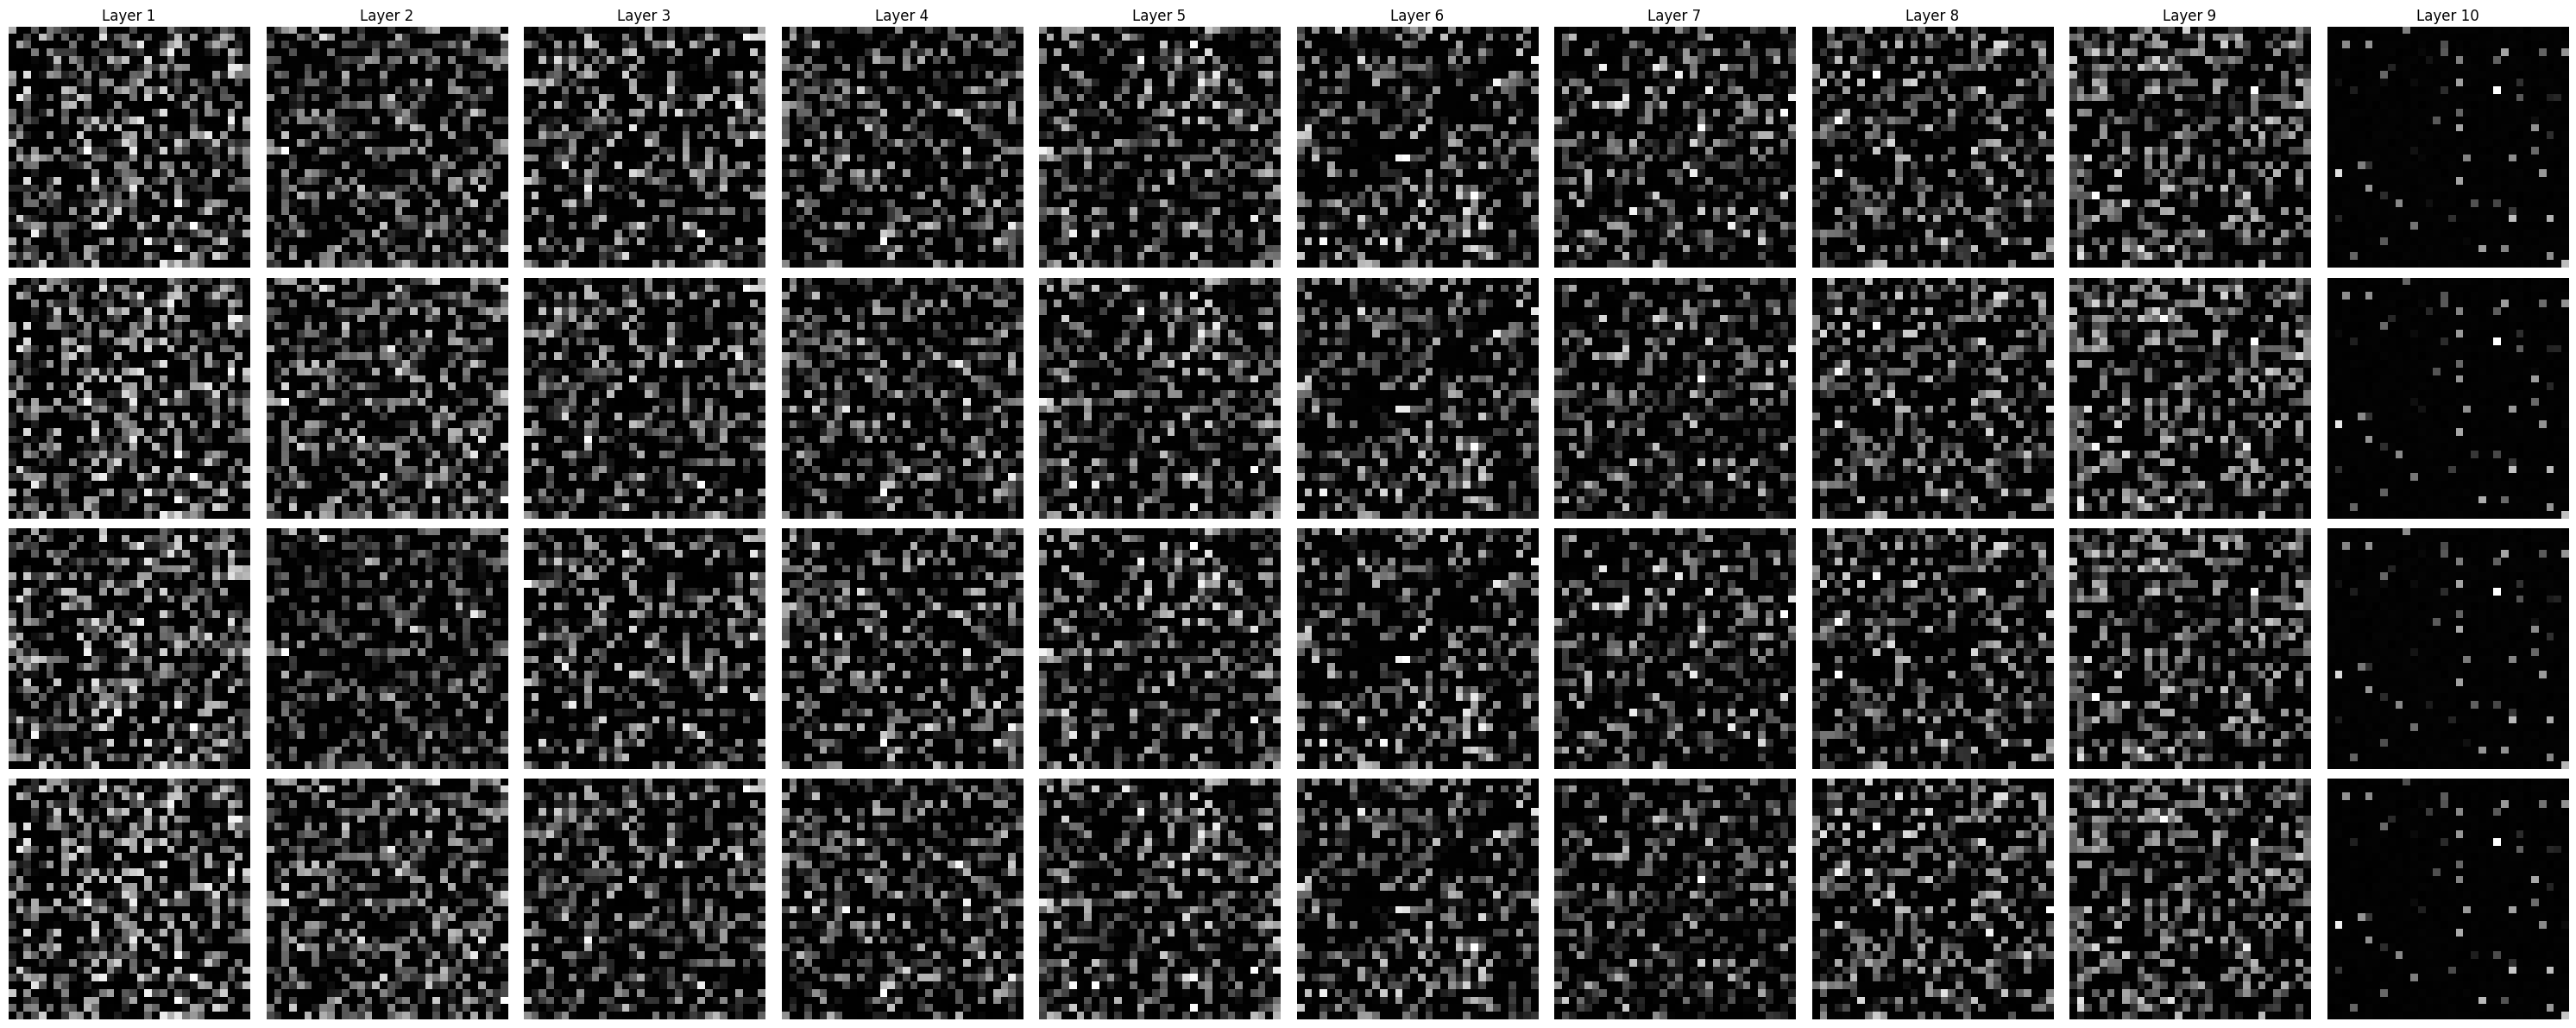

In [4]:
def evaluate_model(model, dataloader):
    # Move the model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    criterion = nn.MSELoss()
    num_samples = 4  # Number of samples to visualize
    sampled_inputs, sampled_targets, sampled_outputs, sampled_activations = [], [], [], []

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            # Move inputs and targets to GPU
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs, activations = model.forward_with_activations(inputs)
            if batch_idx < num_samples:
                sampled_inputs.append(inputs.cpu())  # Store on CPU to avoid GPU memory issues
                sampled_targets.append(targets.cpu())
                sampled_outputs.append(outputs.cpu())
                # Exclude the output layer activation to match 5 layers
                sampled_activations.append([activation.cpu() for activation in activations[:-1]])
            else:
                break  # We only need num_samples samples

    # Plotting
    num_layers = len(sampled_activations[0])  # Should be 5 hidden layers
    fig, axes = plt.subplots(num_samples, num_layers, figsize=(num_layers * 3, num_samples * 3))

    for i in range(num_samples):
        activations = sampled_activations[i]
        for j in range(num_layers):
            activation = activations[j][0].numpy()  # Get activation for the first sample in batch
            # Hidden layer activations (size 1024)
            activation_image = activation.reshape(32, 32)
            ax = axes[i, j]
            ax.imshow(activation_image, cmap='gray')
            ax.axis('off')
            if i == 0:
                ax.set_title(f'Layer {j+1}')

    plt.tight_layout()
    plt.show()
    
evaluate_model(model, dataloader)

# Held-out

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import numpy as np

class GaussianBumpDataset(Dataset):
    def __init__(self, num_samples=1000, grid_size=28, sigma=1.0, holdout_center=False, only_holdout=False):
        self.num_samples = num_samples
        self.grid_size = grid_size
        self.sigma = sigma
        self.holdout_center = holdout_center
        self.only_holdout = only_holdout
        self.data = []
        self.targets = []

        holdout_min = int(0.2 * grid_size)
        holdout_max = int(0.8 * grid_size)

        for _ in range(num_samples):
            while True:
                # Sample continuous values for x and y within grid size
                x, y = np.random.uniform(0, grid_size, size=2)

                # Check if the point falls within the holdout region
                if self.holdout_center and (holdout_min <= x <= holdout_max and holdout_min <= y <= holdout_max):
                    continue  # Skip if point is in the holdout region
                if self.only_holdout and not (holdout_min+2 <= x <= holdout_max-2 and holdout_min+2 <= y <= holdout_max-2):
                    continue  # Skip if point is not in the holdout region

                # Break if a valid point is found
                break

            # Generate the Gaussian bump image
            xv, yv = np.meshgrid(np.arange(grid_size), np.arange(grid_size))
            gaussian_image = 1.0 - np.exp(-((xv - x) ** 2 + (yv - y) ** 2) / (2 * sigma ** 2))

            # Store the coordinates as a 2D vector and the target Gaussian image
            self.data.append(np.array([x, y]))
            self.targets.append(gaussian_image)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        input_coords = torch.tensor(self.data[idx], dtype=torch.float32)  # 2D vector [x, y]
        target_image = torch.tensor(self.targets[idx], dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        return input_coords, target_image
    
# Model Definition with Variable Depth
class MLPDecoder(nn.Module):
    def __init__(self, input_size=2, hidden_sizes=[128, 128], output_size=28*28):
        super(MLPDecoder, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layer = nn.Linear(prev_size, hidden_size)
            nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
            self.hidden_layers.append(layer)
            self.bn_layers.append(nn.BatchNorm1d(hidden_size))
            prev_size = hidden_size
        self.output_layer = nn.Linear(prev_size, output_size)

    def forward(self, x):
        for layer, bn in zip(self.hidden_layers, self.bn_layers):
            x = bn(layer(x))
            x = F.relu(x)
        x = self.output_layer(x)
        x = x.view(-1, 1, 28, 28)
        return x

    def forward_with_activations(self, x):
        activations = []
        for layer in self.hidden_layers:
            x = layer(x)
            x = F.leaky_relu(x)
            activations.append(x.clone())
        x = self.output_layer(x)
        activations.append(x.clone())
        x = x.view(-1, 1, 28, 28)
        return x, activations

# Training Setup
def train_model(model, dataloader, num_epochs=20, learning_rate=1e-3, print_gradients=False, grad_print_interval=1, device="cuda"):
    # Move model to device
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    avg_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            # Move inputs and targets to device
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Optional: Print gradients per layer
            if print_gradients and (epoch % grad_print_interval == 0) and (batch_idx == 0):
                print(f"Epoch {epoch+1}, Batch {batch_idx+1}:")
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        grad_norm = param.grad.data.norm(2).item()
                        print(f"  Layer {name}: Gradient Norm = {grad_norm:.6f}")
                    else:
                        print(f"  Layer {name}: No gradient")
            
            optimizer.step()
            running_loss += loss.item()
    
        avg_loss = running_loss / len(dataloader)
        avg_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
        scheduler.step(avg_loss)
    return avg_losses

# Visualization and Evaluation
def evaluate_model(model, dataloader, device="cuda"):
    model = model.to(device)
    model.eval()
    mse_loss = 0.0
    criterion = nn.MSELoss()
    num_samples = 4
    sampled_inputs, sampled_targets, sampled_outputs = [], [], []

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            # Move inputs and targets to device
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            mse_loss += criterion(outputs, targets).item() * inputs.size(0)

            if batch_idx < num_samples:
                sampled_inputs.append(inputs.cpu())
                sampled_targets.append(targets.cpu())
                sampled_outputs.append(outputs.cpu())

    mse_loss /= len(dataloader.dataset)
    print(f"Mean Squared Error on Evaluation: {mse_loss:.4f}")

    # Plot sampled images
    for i in range(num_samples):
        input_coords = sampled_inputs[i][0].numpy()
        target_image = sampled_targets[i][0].squeeze().numpy()
        output_image = sampled_outputs[i][0].squeeze().numpy()

        x, y = input_coords[0], input_coords[1]

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.title("Target Image")
        plt.imshow(target_image, cmap='gray')
        plt.scatter([x], [y], color='red', marker='x')
        plt.subplot(1, 2, 2)
        plt.title("Reconstructed Image")
        plt.imshow(output_image, cmap='gray')
        plt.scatter([x], [y], color='red', marker='x')
        plt.show()

Epoch [1/200], Loss: 0.2147
Epoch [2/200], Loss: 0.0159
Epoch [3/200], Loss: 0.0163
Epoch [4/200], Loss: 0.0161
Epoch [5/200], Loss: 0.0228
Epoch [6/200], Loss: 0.0095
Epoch [7/200], Loss: 0.0076
Epoch [8/200], Loss: 0.0075
Epoch [9/200], Loss: 0.0077
Epoch [10/200], Loss: 0.0071
Epoch [11/200], Loss: 0.0086
Epoch [12/200], Loss: 0.0160
Epoch [13/200], Loss: 0.0085
Epoch [14/200], Loss: 0.0102
Epoch [15/200], Loss: 0.0069
Epoch [16/200], Loss: 0.0071
Epoch [17/200], Loss: 0.0079
Epoch [18/200], Loss: 0.0081
Epoch [19/200], Loss: 0.0074
Epoch [20/200], Loss: 0.0086
Epoch [21/200], Loss: 0.0062
Epoch [22/200], Loss: 0.0096
Epoch [23/200], Loss: 0.0081
Epoch [24/200], Loss: 0.0074
Epoch [25/200], Loss: 0.0081
Epoch [26/200], Loss: 0.0075
Epoch [27/200], Loss: 0.0064
Epoch [28/200], Loss: 0.0047
Epoch [29/200], Loss: 0.0056
Epoch [30/200], Loss: 0.0053
Epoch [31/200], Loss: 0.0043
Epoch [32/200], Loss: 0.0043
Epoch [33/200], Loss: 0.0041
Epoch [34/200], Loss: 0.0041
Epoch [35/200], Loss: 0

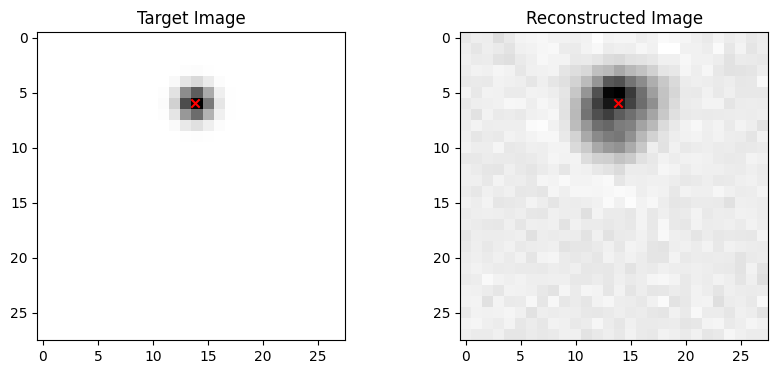

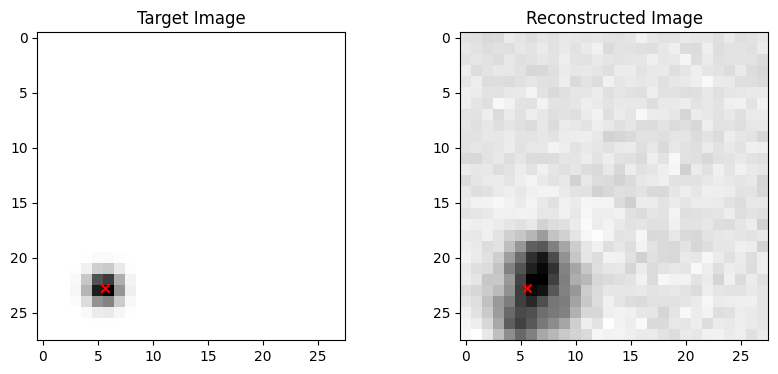

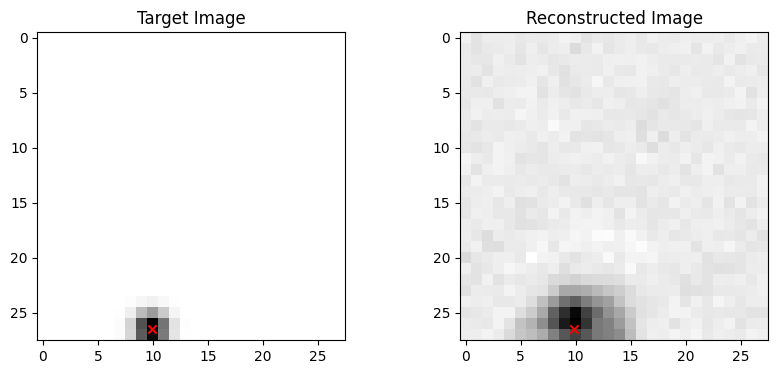

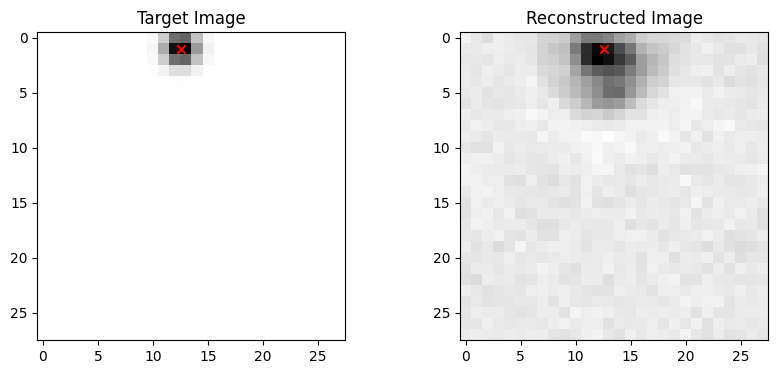

In [5]:
# Hyperparameters
input_size = 2
hidden_sizes = [64*64] * 5
output_size = 28 * 28
batch_size = 32
num_epochs = 200
learning_rate = 1e-3

# Dataset and DataLoader
dataset = GaussianBumpDataset(num_samples=1000, grid_size=28)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model Initialization
model = MLPDecoder(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size)

# Train the model
avg_loss_list2 = train_model(model, dataloader, num_epochs=num_epochs, learning_rate=learning_rate, print_gradients=False)

# Evaluate the model and visualize some samples
evaluate_model(model, dataloader)

Mean Squared Error on Evaluation: 0.0024


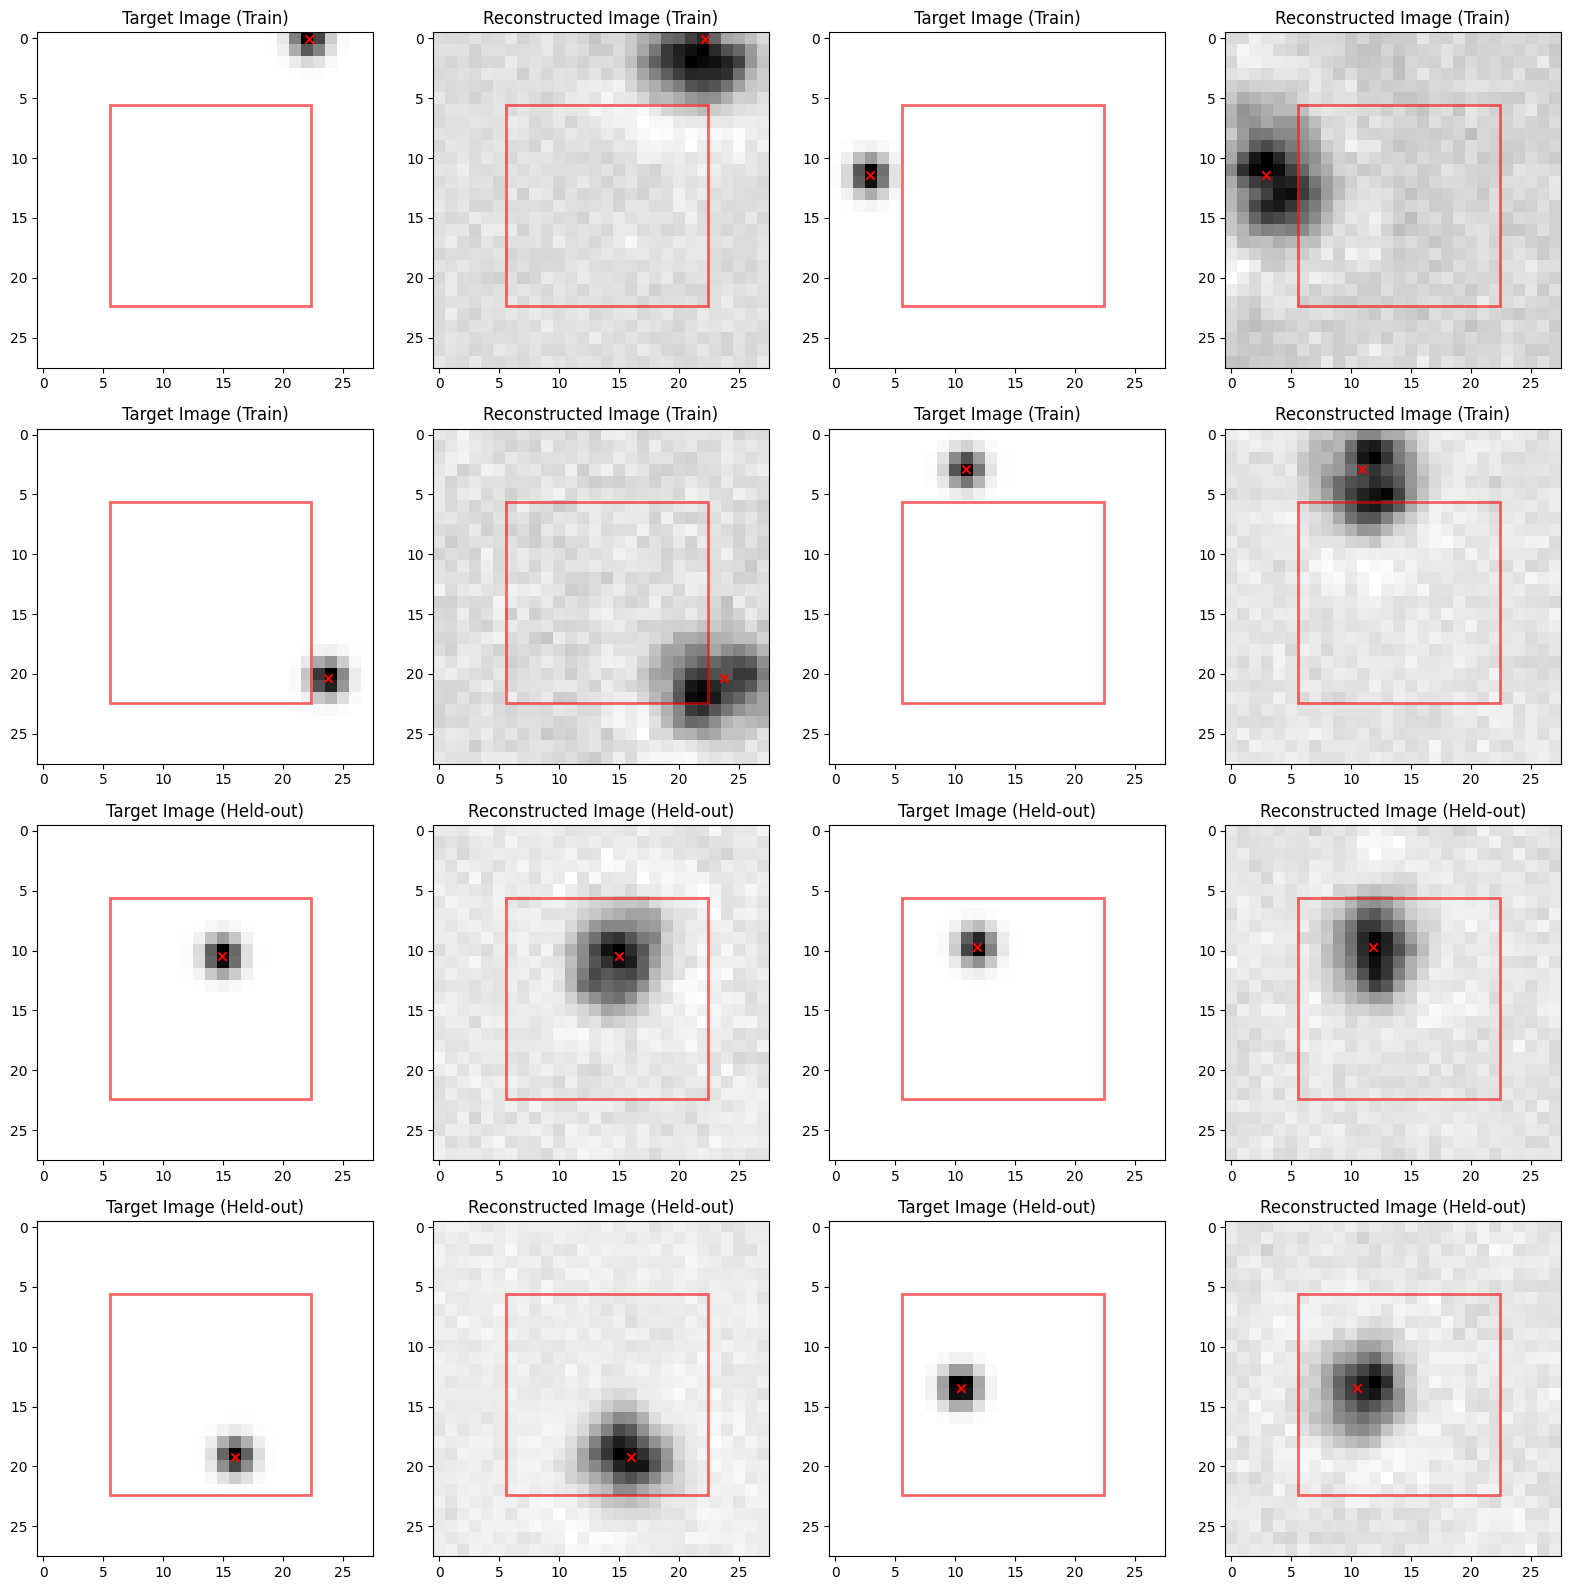

In [6]:
# Dataset and DataLoader for Training (excluding center 6x6 region)
train_dataset = GaussianBumpDataset(num_samples=1000, grid_size=28, holdout_center=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Dataset and DataLoader for Evaluation (only center 6x6 region)
eval_dataset = GaussianBumpDataset(num_samples=100, grid_size=28, only_holdout=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
mse_loss = 0.0
criterion = nn.MSELoss()
num_samples = 4
sampled_inputs, sampled_targets, sampled_outputs = [], [], []
train_sampled_inputs, train_sampled_targets, train_sampled_outputs = [], [], []

with torch.no_grad():
    # Evaluate on held-out data (center 6x6 region)
    for batch_idx, (inputs, targets) in enumerate(eval_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        mse_loss += criterion(outputs, targets).item() * inputs.size(0)

        if len(sampled_inputs) < num_samples:
            sampled_inputs.append(inputs.cpu())  # Move to CPU for visualization
            sampled_targets.append(targets.cpu())
            sampled_outputs.append(outputs.cpu())

    # Sample from training distribution
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        if len(train_sampled_inputs) < num_samples:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            train_sampled_inputs.append(inputs.cpu())  # Move to CPU for visualization
            train_sampled_targets.append(targets.cpu())
            train_sampled_outputs.append(outputs.cpu())
        else:
            break

mse_loss /= len(eval_dataloader.dataset)
print(f"Mean Squared Error on Evaluation: {mse_loss:.4f}")

x_coord = 28 * 0.2
y_coord = 28 * 0.2
length_x = 28 * 0.6
length_y = 28 * 0.6

# Plot sampled images
plt.figure(figsize=(16, 16))
for i in range(len(train_sampled_inputs)):
    input_coords = train_sampled_inputs[i][0].numpy()
    target_image = train_sampled_targets[i][0].squeeze().numpy()
    output_image = train_sampled_outputs[i][0].squeeze().numpy()

    x, y = input_coords  # x and y are already in input_coords

    plt.subplot(4, 4, 2 * i + 1)
    plt.title("Target Image (Train)")
    plt.imshow(target_image, cmap='gray')
    plt.scatter([x], [y], color='red', marker='x')
    plt.gca().add_patch(plt.Rectangle((x_coord, y_coord), length_x, length_y, linewidth=2, edgecolor='red', facecolor='none', alpha=0.6))

    plt.subplot(4, 4, 2 * i + 2)
    plt.title("Reconstructed Image (Train)")
    plt.imshow(output_image, cmap='gray')
    plt.scatter([x], [y], color='red', marker='x')
    plt.gca().add_patch(plt.Rectangle((x_coord, y_coord), length_x, length_y, linewidth=2, edgecolor='red', facecolor='none', alpha=0.6))

for i in range(len(sampled_inputs)):
    input_coords = sampled_inputs[i][0].numpy()
    target_image = sampled_targets[i][0].squeeze().numpy()
    output_image = sampled_outputs[i][0].squeeze().numpy()

    x, y = input_coords  # x and y are already in input_coords

    plt.subplot(4, 4, 8 + 2 * i + 1)
    plt.title("Target Image (Held-out)")
    plt.imshow(target_image, cmap='gray')
    plt.scatter([x], [y], color='red', marker='x')
    plt.gca().add_patch(plt.Rectangle((x_coord, y_coord), length_x, length_y, linewidth=2, edgecolor='red', facecolor='none', alpha=0.6))

    plt.subplot(4, 4, 8 + 2 * i + 2)
    plt.title("Reconstructed Image (Held-out)")
    plt.imshow(output_image, cmap='gray')
    plt.scatter([x], [y], color='red', marker='x')
    plt.gca().add_patch(plt.Rectangle((x_coord, y_coord), length_x, length_y, linewidth=2, edgecolor='red', facecolor='none', alpha=0.6))

plt.tight_layout()
plt.show()
